In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


from timm import create_model
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from torch import optim, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary
import transformers
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer,\
        get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer


import cv2

from PIL import Image
from tqdm.auto import tqdm

import json
from itertools import product

import datasets
from datasets import Dataset, concatenate_datasets
import argparse
import requests

from io import BytesIO
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from IPython import display
import more_itertools

In [2]:
# Global constants 
DATA_PATH = 'data/'
HIDDEN_DIM = 2*768+312
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
BATCH_SIZE = 8

TABLE_FILE_NAME = 'new_labeled_v4.csv'
# TABLE_FILE_NAME = 'new_labeled_v5.csv'
# TABLE_FILE_NAME = 'new_labeled'

IMG_DIR_NAME = 'images7k'

In [ ]:
# Load data

labeled = pd.read_csv(DATA_PATH + TABLE_FILE_NAME)
images_dir = DATA_PATH + IMG_DIR_NAME

y = labeled.label.values
X = labeled.drop(columns='label').copy()

test_ds = SiameseRuCLIPDataset(X, y, images_dir=images_dir)
test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [20]:
import pandas as pd
labeled = pd.read_csv('data/'+'new_labeled_v4.csv') # new_labeled
labeled = labeled.sample(frac=1)

In [4]:
border = int(labeled.shape[0]*(1-.2))
train_index, valid_index = labeled.iloc[:border].index, labeled.iloc[border:].index
X, y = labeled.drop(columns='label'), labeled.label.values

In [5]:
y[train_index]

array([1, 0, 1, ..., 0, 0, 1], shape=(44910,))

In [21]:
os.listdir('data/images_prelabeled')

FileNotFoundError: [Errno 2] No such file or directory: 'data/images_prelabeled'

In [7]:
downloaded_images = set()
for name in os.listdir('data/images_prelabeled'):
    if name.find('copy') > -1:
        os.remove('data/images_prelabeled/'+name)
        continue
    dot_ind = name.find('.')
    sku = int(name[:dot_ind])
    downloaded_images.add(sku)

FileNotFoundError: [Errno 2] No such file or directory: 'data/images_prelabeled'

In [53]:
new_syntetic_data = pd.read_csv('new_syntetic_data.csv')

In [56]:
syntetic_data = pd.read_csv('new_syntetic_data.csv')
new_labeled_v2 = pd.read_csv('data/new_labeled_v2.csv')

In [57]:
new_labeled_v3 = pd.concat([new_labeled_v2, syntetic_data]).dropna(ignore_index=True)

In [61]:
new_labeled_v3.to_csv('data/new_labeled_v4.csv', index=False)

In [35]:
problems_inds = new_labeled_v3[new_labeled_v3.sku_first == 223703337].index
new_labeled_v3 = new_labeled_v3[~new_labeled_v3.index.isin(problems_inds)]

In [28]:
data_parser = DataParser()
data_parser.make_img_url(223703337)

'https://basket-15.wbbasket.ru/vol2237/part223703/223703337/images/big/1.webp'

In [9]:
Image.open('data/images_7k/' + '223703337.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'data/images_7k/223703337.jpg'

In [22]:
223703337 in new_labeled_v3.sku_first.values

True

In [10]:
DATA_PATH = 'data/'
HIDDEN_DIM = 2*768+312
TRAIN_RESULTS_PATH = DATA_PATH
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
NAME_MODEL_NAME = 'cointegrated/rubert-tiny' # 'DeepPavlov/distilrubert-tiny-cased-conversational-v1'
DESCRIPTION_MODEL_NAME = 'cointegrated/rubert-tiny' # TODO sergeyzh/rubert-tiny-turbo deepvk/USER-base

In [11]:
class RuCLIPtiny(nn.Module):
    def __init__(self):
        super().__init__()
        self.visual = create_model('convnext_tiny',
                                   pretrained=False, # TODO: берём претрейн
                                   num_classes=0,
                                   in_chans=3)  # out 768
        # text_config = DistilBertConfig(**{"vocab_size": 30522,
        #                                   "max_position_embeddings": 512,
        #                                   "n_layers": 3,
        #                                   "n_heads": 12,
        #                                   "dim": 264,
        #                                   "hidden_dim": 792,
        #                                   "model_type": "distilbert"})
        # self.transformer = DistilBertModel(text_config)
        self.transformer = AutoModel.from_pretrained(NAME_MODEL_NAME) # 312
        self.final_ln = torch.nn.Linear(312, 768) # 312 -> 768
        self.logit_scale = torch.nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    @property
    def dtype(self):
        return self.visual.stem[0].weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, input_ids, attention_mask):
        x = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        x = x.last_hidden_state[:, 0, :]
        x = self.final_ln(x)
        return x

    def forward(self, image, input_ids, attention_mask):
        image_features = self.encode_image(image)
        text_features = self.encode_text(input_ids, attention_mask)

        # normalized features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text

In [12]:
def get_transform():
    return transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        _convert_image_to_rgb,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]), ])

def _convert_image_to_rgb(image):
    return image.convert("RGB")

class Tokenizers:
    def __init__(self):
        self.name_tokenizer = AutoTokenizer.from_pretrained(NAME_MODEL_NAME)
        self.desc_tokenizer = AutoTokenizer.from_pretrained(DESCRIPTION_MODEL_NAME)

    def tokenize_name(self, texts, max_len=77):
        tokenized = self.name_tokenizer.batch_encode_plus(texts,
                                                     truncation=True,
                                                     add_special_tokens=True,
                                                     max_length=max_len,
                                                     padding='max_length',
                                                     return_attention_mask=True,
                                                     return_tensors='pt')
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])
    
    def tokenize_description(self, texts, max_len=77):
        tokenized = self.desc_tokenizer(texts,
                                        truncation=True,
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        return_tensors='pt')
        return torch.stack([tokenized["input_ids"], tokenized["attention_mask"]])

In [13]:
class SiameseRuCLIPDataset(torch.utils.data.Dataset):
    def __init__(self, df=None, labels=None, df_path=None, images_dir=DATA_PATH+'images/'):
        # loads data either from path using `df_path` or directly from `df` argument
        self.df = pd.read_csv(df_path) if df_path is not None else df
        self.labels = labels
        self.images_dir = images_dir
        self.tokenizers = Tokenizers()
        self.transform = get_transform()
        # 
        self.max_len = 77
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        name_tokens = self.tokenizers.tokenize_name([str(row.name_first), 
                                               str(row.name_second)], max_len=self.max_len)
        name_first = name_tokens[:, 0, :] # [input_ids, attention_mask]
        name_second = name_tokens[:, 1, :]
        desc_tokens = self.tokenizers.tokenize_description([str(row.description_first), 
                                               str(row.description_second)])
        desc_first = desc_tokens[:, 0, :] # [input_ids, attention_mask]
        desc_second = desc_tokens[:, 1, :]
        im_first = cv2.imread(os.path.join(self.images_dir, row.image_name_first))
        im_first = cv2.cvtColor(im_first, cv2.COLOR_BGR2RGB)
        im_first = Image.fromarray(im_first)
        im_first = self.transform(im_first)
        im_second = cv2.imread(os.path.join(self.images_dir, row.image_name_second))
        im_second = cv2.cvtColor(im_second, cv2.COLOR_BGR2RGB)
        im_second = Image.fromarray(im_second)
        im_second = self.transform(im_second)
        label = self.labels[idx]
        return im_first, name_first, desc_first, im_second, name_second, desc_second, label

    def __len__(self,):
        return len(self.df)

In [14]:
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        last_hidden = last_hidden_states.masked_fill(
            ~attention_mask[..., None].bool(), 0.0
        )
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

class SiameseRuCLIP(nn.Module):
    def __init__(self, preload_ruclip=False, device='cpu', hidden_dim=HIDDEN_DIM, models_dir=DATA_PATH + 'train_results/'):
        super().__init__()
        self.ruclip = RuCLIPtiny()
        if preload_ruclip:
            preload_model_name = 'cc12m_rubert_tiny_ep_1.pt' #'cc12m_ddp_4mill_ep_4.pt'
            std = torch.load(models_dir + preload_model_name, weights_only=True, map_location=device)
            self.ruclip.load_state_dict(std)
            self.ruclip = self.ruclip.to(device)
            self.ruclip.eval()
        self.description_transformer = AutoModel.from_pretrained(DESCRIPTION_MODEL_NAME)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            # # nn.BatchNorm1d(hidden_dim),
            # nn.Linear(hidden_dim, hidden_dim // 2),
            # nn.ReLU(), 
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
        )
        
    def encode_description(self, desc):
        # desc is [input_ids, attention_mask]
        last_hidden_states = self.description_transformer(desc[:, 0, :], desc[:, 1, :]).last_hidden_state
        attention_mask = desc[:, 1, :]
        # TODO: нужно ли делать пулинг, посмотреть на результаты
        return average_pool(last_hidden_states, attention_mask)
    
    def forward(self, im1, name1, desc1, im2, name2, desc2):
        image_emb1 = self.ruclip.encode_image(im1)
        image_emb2 = self.ruclip.encode_image(im2)
        name_emb1 = self.ruclip.encode_text(name1[:, 0, :], name1[:, 1, :])
        name_emb2 = self.ruclip.encode_text(name2[:, 0, :], name2[:, 1, :])
        desc_emb1 = self.encode_description(desc1) 
        desc_emb2 = self.encode_description(desc2)
        first_emb = torch.cat([image_emb1, name_emb1, desc_emb1], dim=1)
        second_emb = torch.cat([image_emb2, name_emb2, desc_emb2], dim=1)
        out1 = self.head(first_emb)
        out2 = self.head(second_emb)
        return out1, out2

In [15]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        pos = (1-label) * torch.pow(euclidean_distance, 2)
        neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

In [16]:
CONTRASTIVE_MARGIN=1.5
CONTRASTIVE_THRESHOLD=0.3

In [17]:
def train(model, optimizer, criterion, 
          epochs_num, train_loader, valid_loader=None, 
          score=f1_score, device='cpu', print_epoch=False) -> None:
    model.train()
    model.to(device)
    counter = []
    loss_history = [] 
    it_number = 0
    best_valid_score = 0
    best_valid_score = 100
    best_weights = None
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                               factor=0.1, patience=2,
                                                               threshold=0.0001,
                                                               threshold_mode='rel', cooldown=0,
                                                               min_lr=0, eps=1e-08)
    for epoch in range(epochs_num):
        print("Epoch：", epoch)
        for i, data in enumerate(tqdm(train_loader)):
            im1, name1, desc1, im2, name2, desc2, label = data 
            im1, name1, desc1, im2, name2, desc2, label = im1.to(device), name1.to(device), desc1.to(device), im2.to(device), name2.to(device), desc2.to(device), label.to(device)
            optimizer.zero_grad() 
            out1, out2 = model(im1, name1, desc1, im2, name2, desc2)
            loss = criterion(out1, out2, label)
            loss.backward()
            optimizer.step()
            if i % 1 == 0: # show changes of loss value after each 10 batches
                # it_number += 5
                counter.append(it_number)
                loss_history.append(loss.item())
        # test after each epoch
        if print_epoch:
            valid_score = validation(model, criterion, valid_loader, score, device)
            plot_epoch(loss_history)
            print(f'Current loss: {loss}')
            # print(f'Current {score.__name__}: {valid_score}')
            scheduler.step(valid_score)
            if valid_score < best_valid_score:
                best_valid_score = valid_score
                best_weights = model.state_dict()
    return best_valid_score, best_weights

def evaluate_pair(output1, output2, target, threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    # меньше границы, там где будет True — конкуренты
    cond = euclidean_distance < threshold
    pos_sum = 0
    neg_sum = 0
    pos_acc = 0
    neg_acc = 0

    for i in range(len(cond)):
        # 1 значит не конкуренты
        if target[i]:
            neg_sum+=1
            # 0 в cond значит дальше друг от друга чем threshold
            if not cond[i]:
                neg_acc+=1
        elif not target[i]:
            pos_sum+=1
            if cond[i]:
                pos_acc+=1

    return pos_acc, pos_sum, neg_acc, neg_sum

def validation(model, criterion, valid_loader, score, device='cpu') -> float:
    valid_loss = 0
    val_pos_accuracy = 0
    val_neg_accuracy = 0
    num_pos = 0
    num_neg = 0
    with torch.no_grad(): 
        # model.eval()
        for data in tqdm(valid_loader):
            im1, name1, desc1, im2, name2, desc2, label = data 
            im1, name1, desc1, im2, name2, desc2, label = im1.to(device), name1.to(device), desc1.to(device), im2.to(device), name2.to(device), desc2.to(device), label.to(device)
            out1, out2 = model(im1, name1, desc1, im2, name2, desc2) 
            loss = criterion(out1, out2, label)
            pos_acc, pos_sum, neg_acc, neg_sum = evaluate_pair(out1, out2, label, CONTRASTIVE_THRESHOLD)
            val_pos_accuracy+=pos_acc
            val_neg_accuracy+=neg_acc
            num_pos+=pos_sum
            num_neg+=neg_sum
            valid_loss += loss.item()
            # print(predicted)
            # print(label)
            # predicted = predicted.cpu().numpy()
            # valid_loss += score(label, predicted)
    val_pos_accuracy /= num_pos
    val_neg_accuracy /= num_neg
    valid_loss /= len(valid_loader)
    print("Validation loss :{} \t\t\t P Acc : {}, N Acc: {}\n".format(valid_loss, val_pos_accuracy, val_neg_accuracy))
    return valid_loss

def plot_epoch(loss_history)->None:
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Training loss")
    plt.xlabel("Iteration number")
    plt.ylabel("Loss")
    plt.plot(loss_history, 'b')
    plt.show()

In [18]:
images_dir = DATA_PATH + 'images_5k/'
labeled = pd.read_csv(DATA_PATH + 'new_labeled.csv')
labeled = labeled.sample(frac=1)

In [19]:
BATCH_SIZE=70
EPOCHS=10
EMB_SIZE=768
VALIDATION_SPLIT=.2
SHUFFLE_DATASET=True
RANDOM_SEED=42
NUM_WORKERS=6
LR=9e-5
MOMENTUM=0.9
N_SPLITS=3
WEIGHT_DECAY=1e-3
CONTRASTIVE_MARGIN=1.5

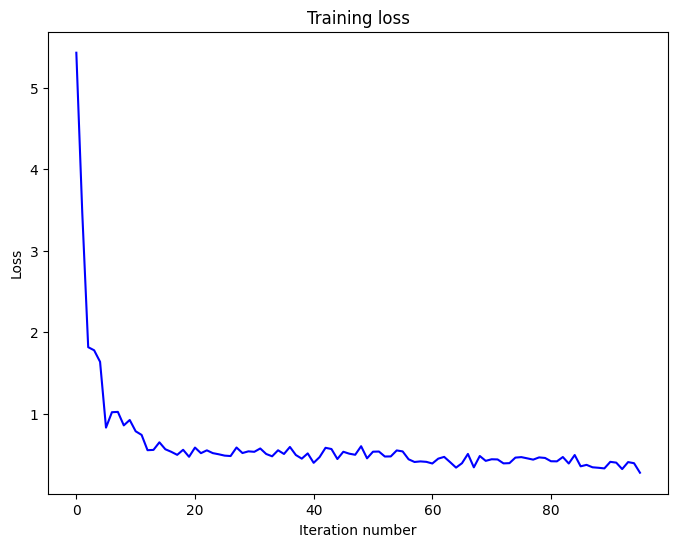

Current loss: 0.2764648497104645
Current f1_score: 0.39869005357225734
Epoch： 2


  0%|          | 0/48 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
skf = StratifiedKFold(n_splits=N_SPLITS)
nn_scores = list()
X, y = labeled.drop(columns='label'), labeled.label.values
y = 1 - y 
best_valid = 100
for train_index, valid_index in skf.split(X, y): # разбивка по индексам
    train_dataset = SiameseRuCLIPDataset(X.iloc[train_index], y[train_index], images_dir=images_dir)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    valid_dataset = SiameseRuCLIPDataset(X.iloc[valid_index], y[valid_index], images_dir=images_dir)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
    
    model = SiameseRuCLIP(device=DEVICE)
    # for i, child in enumerate(model.children()):
    #     for param in model.ruclip.parameters():
    #         param.requires_grad = False
    # model.ruclip.visual.stages[3].blocks[2].mlp.fc2.requires_grad = True
    criterion = ContrastiveLoss(margin=CONTRASTIVE_MARGIN)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    best_valid_score, best_weights = train(model, optimizer, criterion,
        EPOCHS, train_loader, valid_loader, 
        score=f1_score, print_epoch=True, device=DEVICE)
    nn_scores.append(best_valid_score)
    if best_valid_score < best_valid:
        best_valid = best_valid_score
        torch.save(best_weights, 'siamese_contrastive.pt')

np.mean(nn_scores)

In [ ]:
def predict(out1, out2, threshold=CONTRASTIVE_THRESHOLD):
    # вернёт 1 если похожи
    return F.pairwise_distance(out1, out2) < threshold

In [10]:
pdist = nn.PairwiseDistance(p=2)
output = F.pairwise_distance(input1, input2)